In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import argparse
import os
import copy

from sklearn.mixture import GaussianMixture


LABELS_Severity = {35: 0,
                   43: 0,
                   47: 1,
                   53: 1,
                   61: 2,
                   65: 2,
                   71: 2,
                   85: 2}


mean = (.1706)
std = (.2112)
normalize = transforms.Normalize(mean=mean, std=std)

transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize,
])
    
class OCTDataset(Dataset):
    def __init__(self, args, subset='train', transform=None,):
        if subset == 'train':
            self.annot = pd.read_csv('df_prime_train.csv')
        elif subset == 'test':
            self.annot = pd.read_csv('df_prime_test.csv')
            
        self.annot['Severity_Label'] = [LABELS_Severity[drss] for drss in copy.deepcopy(self.annot['DRSS'].values)] 
        # print(self.annot)
        self.root = os.path.expanduser('/storage/home/hpaceice1/shared-classes/materials/ece8803fml')
        self.transform = transform
        # self.subset = subset
        self.nb_classes=len(np.unique(list(LABELS_Severity.values())))
        self.path_list = self.annot['File_Path'].values
        self._labels = self.annot['Severity_Label'].values
        assert len(self.path_list) == len(self._labels)
        # idx_each_class = [[] for i in range(self.nb_classes)]
        print("Sucess")

    def __getitem__(self, index):
        img, target = Image.open(self.root+self.path_list[index]).convert("L"), self._labels[index]

        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self._labels)         

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--annot_train_prime', type = str, default = 'df_prime_train.csv')
    parser.add_argument('--annot_test_prime', type = str, default = 'df_prime_test.csv')
    parser.add_argument('--data_root', type = str, default = '')
    return parser.parse_args()

if __name__ == '__main__':
    args = 0
    trainset = OCTDataset(args, 'train', transform=transform)
    testset = OCTDataset(args, 'test', transform=transform)
    #gmm = GaussianMixture(n_components=3)
    #print(trainset._labels)
    #for sample in trainset:
    #    for im in sample:
            #print(im.shape)
    #        features = im.reshape(-1,1)
            #print(features.shape)
            #print(features)
            #gmm.fit(features)
    print(len(trainset), len(testset))

Sucess
Sucess
24252 7987


In [2]:
X_train = np.empty([len(trainset),50176])
for data in range(len(trainset)):
    X_train[data] = trainset[data][0].reshape(1,-1).numpy()

y_train = trainset._labels

X_test = np.empty([len(testset),50176])
for data in range(len(testset)):
    X_test[data] = testset[data][0].reshape(1,-1).numpy()

y_test = testset._labels

from sklearn import svm
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24252, 50176)
(24252,)
(7987, 50176)
(7987,)


In [3]:
SVM = svm.SVC(kernel = 'rbf', C=0.01, gamma = 0.1)
SVM.fit(X_train, y_train)
#SVM.score(X_test, y_test)

SVC(C=0.01, gamma=0.1)

In [3]:
SVM = svm.SVC(kernel = 'poly', C=1.0)
SVM.fit(X_train, y_train)

SVC(kernel='poly')

In [3]:
SVM = svm.SVC(kernel = 'poly', degree = 8, C=1.0)
SVM.fit(X_train, y_train)

SVC(degree=8, kernel='poly')

In [3]:
SVM = svm.SVC(kernel = 'linear', C=1.0)
SVM.fit(X_train, y_train)

SVC(kernel='linear')

In [4]:
from joblib import dump, load

In [5]:
#save the traineed model
dump(SVM, 'SVM.joblib', compress = 5) 

['SVM_linear.joblib']

In [4]:
#oad the pre-trained model
SVM = load('SVM.joblib')

In [6]:
from sklearn.metrics import balanced_accuracy_score
y_pred = SVM.predict(X_test)

In [7]:
balanced_accuracy_score(y_test, y_pred)

0.3527706740264344

In [8]:
from sklearn.metrics import accuracy_score

In [9]:
accuracy_score(y_test, y_pred)

0.4178039313885063

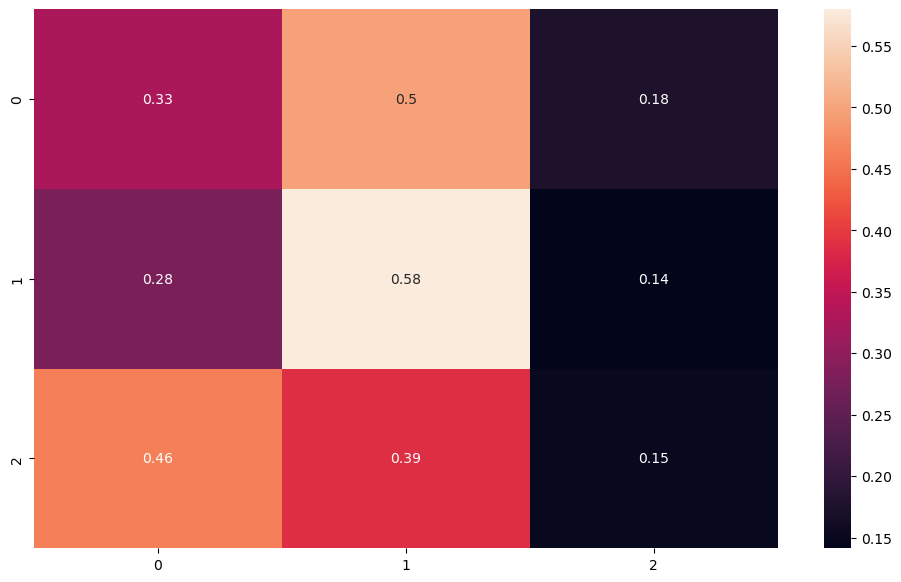

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# Build confusion matrix
cf_matrix = confusion_matrix(testset._labels, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in range(3)],
                     columns = [i for i in range(3)])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('confussion_matrix_SVM_linear.png')